In [1]:
!pip install --user face-recognition

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import sampler
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm_notebook, tnrange
import xml.etree.ElementTree as ET
import copy
import face_recognition

In [3]:
dtype = torch.float32 

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [8]:
widths = []
heights = []
for annotation_file in sorted(os.listdir('./input/Face_Mask_Dataset/annotations')):
    annotation_path = os.path.join('./input/Face_Mask_Dataset/annotations', annotation_file)

    # https://www.kaggle.com/bitthal/understanding-input-data-and-loading-with-pytorch
    tree = tree = ET.parse(annotation_path)
    root = tree.getroot()
    objects = root.findall('object')
    for obj in objects:
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        widths.append(xmax - xmin)
        heights.append(ymax - ymin)
        
np.mean(widths), np.mean(heights)

(31.149066797642437, 35.0049115913556)

In [9]:
total_num_images = 4072
train_indices = (0, int(0.80 * total_num_images))
val_indices = (int(0.80 * total_num_images), int(0.9 * total_num_images))
test_indices =  (int(0.9 * total_num_images), total_num_images)
train_indices, val_indices, test_indices

((0, 3257), (3257, 3664), (3664, 4072))

In [10]:
class FaceMaskDataset(Dataset):
    def __init__(self, img_dir, annotations_dir, indices):
        self.img_dir = img_dir
        self.label_dict = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}
        self.faces = []
        
        for annotation_file in sorted(os.listdir(annotations_dir)):
            annotation_path = os.path.join(annotations_dir, annotation_file)

            # https://www.kaggle.com/bitthal/understanding-input-data-and-loading-with-pytorch
            tree = tree = ET.parse(annotation_path)
            root = tree.getroot()
            filename = root.find('filename').text
            objects = root.findall('object')
            for obj in objects:
                label = self.label_dict[obj.find('name').text]
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                bbox = (xmin, ymin, xmax, ymax)
                self.faces.append((filename, bbox, label))
        
        self.faces = self.faces[indices[0]:indices[1]]
                        
    def __len__(self):
        return len(self.faces)

    def __getitem__(self, idx):
        image_path = os.path.join(self.img_dir, self.faces[idx][0])
        img = Image.open(image_path).convert('RGB')
        cropped_img = img.crop(self.faces[idx][1])
        # Normalize stats from ImageNet
        compose = T.Compose([
            T.Resize((35, 35)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
        
        return compose(cropped_img), self.faces[idx][2], idx

In [11]:
train_face_mask_dataset = FaceMaskDataset(img_dir='./input/Face_Mask_Dataset/images', annotations_dir='./input/Face_Mask_Dataset/annotations', indices=train_indices)
train_face_mask_dataloader = DataLoader(train_face_mask_dataset, batch_size=128, shuffle=True)

valid_face_mask_dataset = FaceMaskDataset(img_dir='./input/Face_Mask_Dataset/images', annotations_dir='./input/Face_Mask_Dataset/annotations', indices=val_indices)
valid_face_mask_dataloader = DataLoader(valid_face_mask_dataset, batch_size=128)

test_face_mask_dataset = FaceMaskDataset(img_dir='./input/Face_Mask_Dataset/images', annotations_dir='./input/Face_Mask_Dataset/annotations', indices=test_indices)
test_face_mask_dataloader = DataLoader(test_face_mask_dataset, batch_size=128)

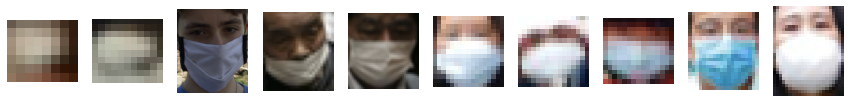

In [12]:
figs, axs = plt.subplots(1, 10, figsize=(15,15))

tmp_dataset = FaceMaskDataset(img_dir='./input/Face_Mask_Dataset/images', annotations_dir='./input/Face_Mask_Dataset/annotations', indices=test_indices)
count = 0
# Boiler plate code to display some of the images
for img, label, idx in DataLoader(tmp_dataset, batch_size=1):
    orig_image = Image.open(os.path.join(tmp_dataset.img_dir, tmp_dataset.faces[idx][0])).convert('RGB')
    cropped_img = orig_image.crop(tmp_dataset.faces[idx][1])
    axs[count].imshow(cropped_img)
    axs[count].axis('off')
    count += 1
    if count == 10:
        break

In [13]:
num_mask = 0
num_no_mask = 0
num_bad_mask = 0
for imgs, labels, _ in train_face_mask_dataloader:
    num_mask += (labels == 0).sum().item()
    num_no_mask += (labels == 1).sum().item()
    num_bad_mask += (labels == 2).sum().item()
    
num_mask, num_no_mask, num_bad_mask

(2551, 608, 98)

In [14]:
len(train_face_mask_dataloader), len(valid_face_mask_dataloader), len(test_face_mask_dataloader)

(26, 4, 4)

In [15]:
# Referenced Nikhil Pathak's ECE 176 Final Project on Image Colorization: https://github.com/nlpathak/ImageColorization
def evaluate(split, model, loss_func, current_best):
    dataloader = valid_face_mask_dataloader if split == 'val' else train_face_mask_dataloader
    losses = []
    accuracies = []
    
    model.eval() 
    with torch.no_grad():
        for imgs, labels, _ in dataloader:
            imgs = imgs.to(device=device, dtype=dtype) 
            labels = labels.to(device=device, dtype=torch.long)
            scores = model(imgs)
            
            losses.append(loss_func(scores, labels).item())
            accuracies.append(torch.sum(torch.argmax(scores, axis=1) == labels).item() / labels.shape[0])
    
    mean_loss = np.mean(losses)
    mean_acc = np.mean(accuracies)
    
    if split == 'train':
        return mean_loss, mean_acc, None
    
    if mean_loss < current_best["loss"]:
        current_best["loss"] = mean_loss
        current_best["acc"] = mean_acc
        current_best["model"] = copy.deepcopy(model)
        
    return mean_loss, mean_acc, current_best
        
def train(model, optimizer, loss_func, epochs=1):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    current_best = {
        "loss": float('inf'),
        "acc": 0, 
        "model": model
    } 
    
    model = model.to(device=device) 
    for e in tnrange(epochs):
        for imgs, labels, _ in train_face_mask_dataloader:
            model.train()  
            imgs = imgs.to(device=device, dtype=dtype)  
            labels = labels.to(device=device, dtype=torch.long)

            scores = model(imgs)
            loss = loss_func(scores, labels)
            
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

        train_loss, train_acc, _ = evaluate('train', model, loss_func, None)    
        val_loss, val_acc, current_best = evaluate('val', model, loss_func, current_best)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch {e}, train loss = {train_losses[-1]:.6f}, train acc = {train_accs[-1]:.6f}, \
                val loss = {val_losses[-1]:.6f}, val acc = {val_accs[-1]:.6f}')
        
    return train_losses, train_accs, val_losses, val_accs, current_best

def test(model, loss_func):
    losses = []
    accuracies = []
    
    mask_total = 0
    no_mask_total = 0
    incorrect_mask_total = 0
    mask_correct = 0
    no_mask_correct = 0
    incorrect_mask_correct = 0 

    model = model.to(device=device) 

    model.eval() 
    with torch.no_grad():
        for imgs, labels, _ in test_face_mask_dataloader:
            imgs = imgs.to(device=device, dtype=dtype) 
            labels = labels.to(device=device, dtype=torch.long)
            scores = model(imgs)
            
            preds = torch.argmax(scores, axis=1)
            
            losses.append(loss_func(scores, labels).item())
            accuracies.append(torch.sum(preds == labels).item() / labels.shape[0])
            
            mask_indices = (labels == 0).nonzero()
            no_mask_indices = (labels == 1).nonzero()
            incorrect_mask_indices = (labels == 2).nonzero()
            
            mask_total += mask_indices.shape[0]
            no_mask_total += no_mask_indices.shape[0]
            incorrect_mask_total += incorrect_mask_indices.shape[0]
            
            mask_correct += torch.sum(preds[mask_indices] == labels[mask_indices]).item() 
            no_mask_correct += torch.sum(preds[no_mask_indices] == labels[no_mask_indices]).item() 
            incorrect_mask_correct += torch.sum(preds[incorrect_mask_indices] == labels[incorrect_mask_indices]).item()

    mean_loss = np.mean(losses)
    mean_acc = np.mean(accuracies)
    
    print(f'Mask Accuracy: {mask_correct}/{mask_total} -> {mask_correct / mask_total:.5f}')
    print(f'No Mask Accuracy: {no_mask_correct}/{no_mask_total} -> {no_mask_correct / no_mask_total:.5f}')
    print(f'Incorrect Mask Accuracy: {incorrect_mask_correct}/{incorrect_mask_total} -> {incorrect_mask_correct / incorrect_mask_total:.5f}')
      
    return mean_loss, mean_acc, mask_correct / mask_total, no_mask_correct / no_mask_total, incorrect_mask_correct / incorrect_mask_total

def test_predict(model):
    loader = DataLoader(test_face_mask_dataset, batch_size=1, shuffle=True)
    
    predict_dict = {0: 'Correctly Masked', 1: 'Not Masked', 2: 'Incorrectly Masked'}
    
    figs, axs = plt.subplots(1, 10, figsize=(15,15))

    model = model.to(device='cpu') 
    model.eval() 
    with torch.no_grad():
        for count, (imgs, labels, idx) in enumerate(loader):
            if count == 10:
                break
            scores = model(imgs)
            preds = torch.argmax(scores, axis=1)
            
            orig_image = Image.open(os.path.join(test_face_mask_dataset.img_dir, test_face_mask_dataset.faces[idx][0])).convert('RGB')
            cropped_img = orig_image.crop(test_face_mask_dataset.faces[idx][1])
            axs[count].imshow(cropped_img)
            axs[count].axis('off')
            axs[count].set_title(predict_dict[preds[0].item()])
    plt.show()

### Non Pretrained Densenet201 ###

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Epoch 0, train loss = 1.022681, train acc = 0.511677,                 val loss = 1.008751, val acc = 0.509086
Epoch 1, train loss = 0.843529, train acc = 0.633361,                 val loss = 0.916212, val acc = 0.592476
Epoch 2, train loss = 0.742733, train acc = 0.686625,                 val loss = 0.876463, val acc = 0.663043
Epoch 3, train loss = 0.660702, train acc = 0.762415,                 val loss = 0.828065, val acc = 0.725798
Epoch 4, train loss = 0.588592, train acc = 0.804935,                 val loss = 0.781664, val acc = 0.767918
Epoch 5, train loss = 0.522516, train acc = 0.827988,                 val loss = 0.759492, val acc = 0.781590
Epoch 6, train loss = 0.465339, train acc = 0.861494,                 val loss = 0.735865, val acc = 0.827870
Epoch 7, train loss = 0.416577, train acc = 0.868026,                 val loss = 0.687132, val acc = 0.835683
Epoch 8, train loss = 0.371775, train acc = 0.895364,                 val loss = 0.673079, val acc = 0.843495
Epoch 9, t

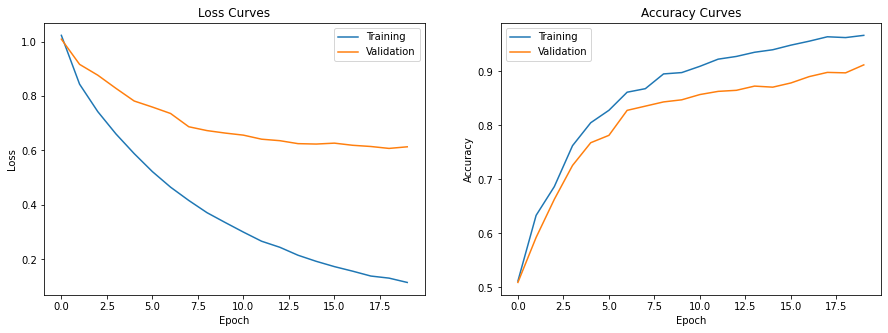

In [33]:
model = models.densenet201(pretrained=False)
print(model)
model.classifier = nn.Linear(in_features=1920, out_features=3, bias=True)

print('point0')
loss_func = nn.CrossEntropyLoss(weight=torch.tensor([98/2551, 98/608, 98/98]).to(device=device))
print('point0.1')
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-2)
print('point0.2')
train_losses, train_accs, val_losses, val_accs, best = train(model, optimizer, loss_func, epochs=20)
print('point1')

#Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(train_losses, label='Training')
axs[0].plot(val_losses, label='Validation')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Loss Curves')
axs[0].legend()

axs[1].plot(train_accs, label='Training')
axs[1].plot(val_accs, label='Validation')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Accuracy Curves')
axs[1].legend()

plt.show()

In [34]:
test(best['model'], loss_func)

Mask Accuracy: 337/353 -> 0.95467
No Mask Accuracy: 31/42 -> 0.73810
Incorrect Mask Accuracy: 3/13 -> 0.23077


(0.8493928164243698,
 0.8938802083333334,
 0.9546742209631728,
 0.7380952380952381,
 0.23076923076923078)

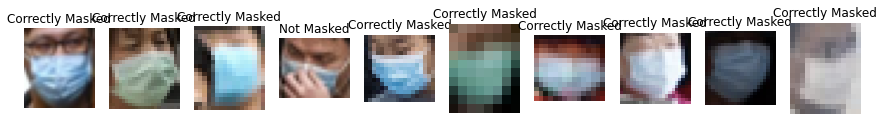

In [35]:
test_predict(best['model'])

In [36]:
torch.save(best['model'].state_dict(), './saved_models/densenet201_notpretrained.pt')

### Pretrained Densenet201 ###

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Epoch 0, train loss = 1.033858, train acc = 0.475766,                 val loss = 1.066635, val acc = 0.422045
Epoch 1, train loss = 0.888018, train acc = 0.613149,                 val loss = 0.988583, val acc = 0.539742
Epoch 2, train loss = 0.776808, train acc = 0.678512,                 val loss = 0.925211, val acc = 0.589674
Epoch 3, train loss = 0.686914, train acc = 0.744992,                 val loss = 0.884896, val acc = 0.656335
Epoch 4, train loss = 0.599631, train acc = 0.807176,                 val loss = 0.841518, val acc = 0.695397
Epoch 5, train loss = 0.530201, train acc = 0.845347,                 val loss = 0.799561, val acc = 0.748387
Epoch 6, train loss = 0.459427, train acc = 0.891990,                 val loss = 0.762117, val acc = 0.784647
Epoch 7, train loss = 0.386399, train acc = 0.912344,                 val loss = 0.717168, val acc = 0.792459
Epoch 8, train loss = 0.333755, train acc = 0.944638,                 val loss = 0.677539, val acc = 0.835428
Epoch 9, t

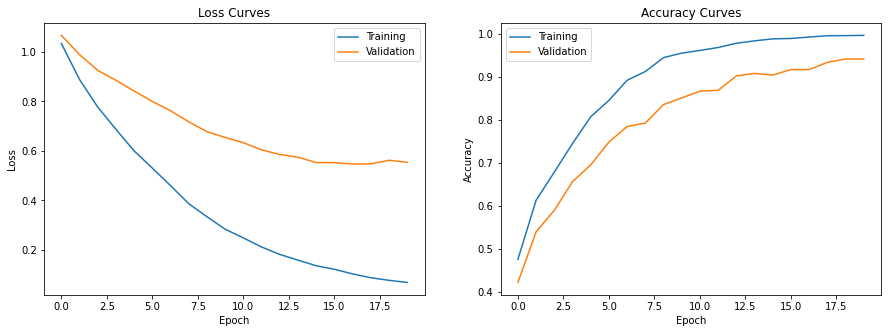

In [38]:
model = models.densenet201(pretrained=True)
print(model)
model.classifier = nn.Linear(in_features=1920, out_features=3, bias=True)

print('point0')
loss_func = nn.CrossEntropyLoss(weight=torch.tensor([98/2551, 98/608, 98/98]).to(device=device))
print('point0.1')
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-2)
print('point0.2')
train_losses, train_accs, val_losses, val_accs, best = train(model, optimizer, loss_func, epochs=20)
print('point1')

#Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(train_losses, label='Training')
axs[0].plot(val_losses, label='Validation')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Loss Curves')
axs[0].legend()

axs[1].plot(train_accs, label='Training')
axs[1].plot(val_accs, label='Validation')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Accuracy Curves')
axs[1].legend()

plt.show()

In [39]:
test(best['model'], loss_func)

Mask Accuracy: 349/353 -> 0.98867
No Mask Accuracy: 40/42 -> 0.95238
Incorrect Mask Accuracy: 3/13 -> 0.23077


(0.6993742436170578,
 0.9602864583333334,
 0.9886685552407932,
 0.9523809523809523,
 0.23076923076923078)

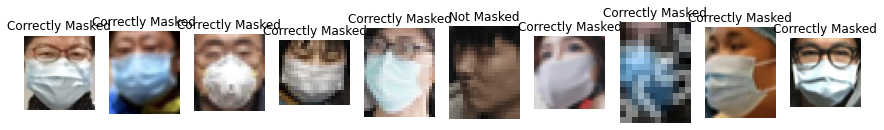

In [40]:
test_predict(best['model'])

In [41]:
torch.save(best['model'].state_dict(), './saved_models/densenet201_pretrained.pt')

### Pretrained Densenet121 ###

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Epoch 0, train loss = 1.024551, train acc = 0.440020,                 val loss = 1.072588, val acc = 0.415336
Epoch 1, train loss = 0.885559, train acc = 0.531956,                 val loss = 1.054885, val acc = 0.432065
Epoch 2, train loss = 0.771777, train acc = 0.601594,                 val loss = 0.978284, val acc = 0.502632
Epoch 3, train loss = 0.690621, train acc = 0.666414,                 val loss = 0.925792, val acc = 0.526919
Epoch 4, train loss = 0.603213, train acc = 0.726663,                 val loss = 0.872544, val acc = 0.612262
Epoch 5, train loss = 0.532968, train acc = 0.770074,                 val loss = 0.833917, val acc = 0.637653
Epoch 6, train loss = 0.473522, train acc = 0.830466,                 val loss = 0.784068, val acc = 0.713230
Epoch 7, train loss = 0.419565, train acc = 0.868996,                 val loss = 0.759126, val acc = 0.784901
Epoch 8, train loss = 0.368901, train acc = 0.888074,                 val loss = 0.738647, val acc = 0.814453
Epoch 9, t

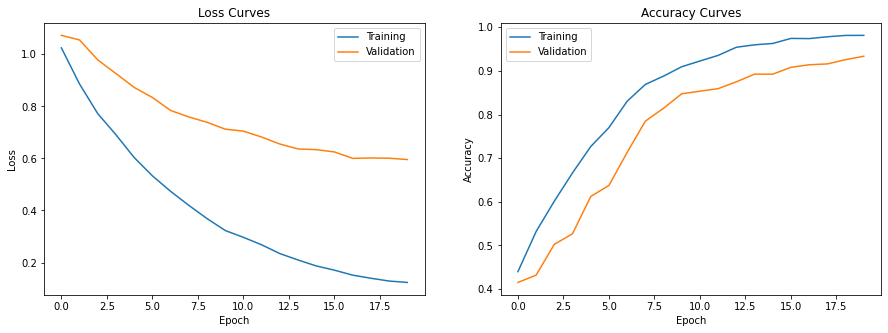

In [44]:
model = models.densenet121(pretrained=True)
print(model)
model.classifier = nn.Linear(in_features=1024, out_features=3, bias=True)

print('point0')
loss_func = nn.CrossEntropyLoss(weight=torch.tensor([98/2551, 98/608, 98/98]).to(device=device))
print('point0.1')
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-2)
print('point0.2')
train_losses, train_accs, val_losses, val_accs, best = train(model, optimizer, loss_func, epochs=20)
print('point1')

#Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(train_losses, label='Training')
axs[0].plot(val_losses, label='Validation')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Loss Curves')
axs[0].legend()

axs[1].plot(train_accs, label='Training')
axs[1].plot(val_accs, label='Validation')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Accuracy Curves')
axs[1].legend()

plt.show()

In [45]:
test(best['model'], loss_func)

Mask Accuracy: 338/353 -> 0.95751
No Mask Accuracy: 38/42 -> 0.90476
Incorrect Mask Accuracy: 4/13 -> 0.30769


(0.6796027272939682,
 0.919921875,
 0.9575070821529745,
 0.9047619047619048,
 0.3076923076923077)

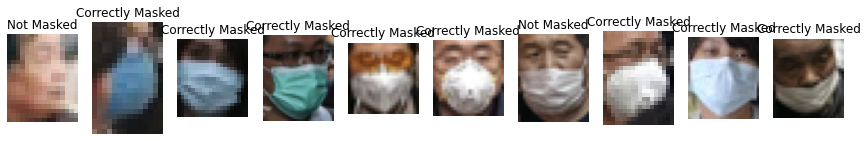

In [46]:
test_predict(best['model'])

In [47]:
torch.save(best['model'].state_dict(), './saved_models/densenet121_pretrained.pt')

### Pretrained Densenet161 ###

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Epoch 0, train loss = 1.034171, train acc = 0.324867,                 val loss = 1.090441, val acc = 0.289827
Epoch 1, train loss = 0.866716, train acc = 0.461280,                 val loss = 1.000364, val acc = 0.371858
Epoch 2, train loss = 0.714225, train acc = 0.665438,                 val loss = 0.965563, val acc = 0.573794
Epoch 3, train loss = 0.608459, train acc = 0.774808,                 val loss = 0.863463, val acc = 0.654976
Epoch 4, train loss = 0.509366, train acc = 0.855854,                 val loss = 0.784836, val acc = 0.759596
Epoch 5, train loss = 0.434116, train acc = 0.911363,                 val loss = 0.795887, val acc = 0.832626
Epoch 6, train loss = 0.363481, train acc = 0.930515,                 val loss = 0.704637, val acc = 0.861923
Epoch 7, train loss = 0.290795, train acc = 0.954106,                 val loss = 0.662383, val acc = 0.882558
Epoch 8, train loss = 0.247838, train acc = 0.967701,                 val loss = 0.613959, val acc = 0.916865
Epoch 9, t

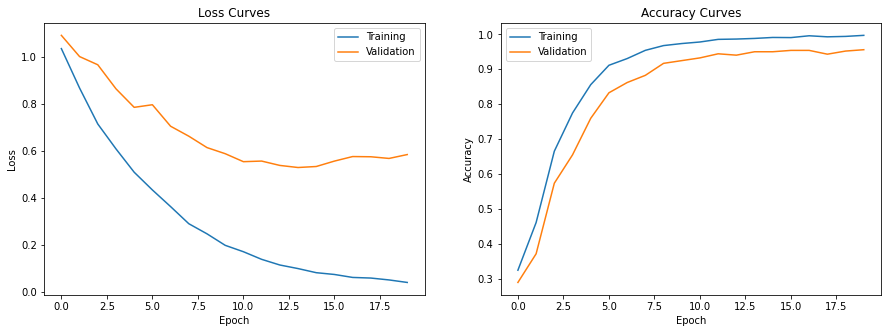

In [49]:
model = models.densenet161(pretrained=True)
print(model)
model.classifier = nn.Linear(in_features=2208, out_features=3, bias=True)

print('point0')
loss_func = nn.CrossEntropyLoss(weight=torch.tensor([98/2551, 98/608, 98/98]).to(device=device))
print('point0.1')
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-2)
print('point0.2')
train_losses, train_accs, val_losses, val_accs, best = train(model, optimizer, loss_func, epochs=20)
print('point1')

#Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(train_losses, label='Training')
axs[0].plot(val_losses, label='Validation')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Loss Curves')
axs[0].legend()

axs[1].plot(train_accs, label='Training')
axs[1].plot(val_accs, label='Validation')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Accuracy Curves')
axs[1].legend()

plt.show()

In [50]:
test(best['model'], loss_func)

Mask Accuracy: 348/353 -> 0.98584
No Mask Accuracy: 40/42 -> 0.95238
Incorrect Mask Accuracy: 6/13 -> 0.46154


(0.523850604891777,
 0.9641927083333334,
 0.9858356940509915,
 0.9523809523809523,
 0.46153846153846156)

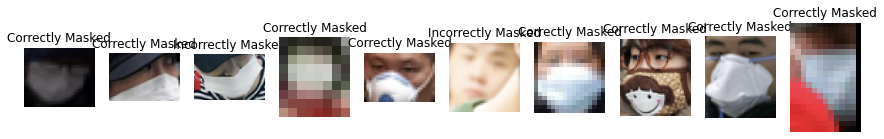

In [51]:
test_predict(best['model'])

In [52]:
torch.save(best['model'].state_dict(), './saved_models/densenet161_pretrained.pt')